In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
# from difflib import SequenceMatcher
import editdistance
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# random.seed(321)
# np.random.seed(321)

X_train = pd.read_json("../input/train.json")
X_test = pd.read_json("../input/test.json")



In [3]:
dfSentiment=pd.read_csv("sentimentFeatureAdded.csv")
#print(dfSentiment.shape)
dfSentiment.index=X_train.index
dfSentiment['manager_id']=X_train['manager_id']
dfSentimentTest=pd.read_csv("sentimentFeatureAddedTest.csv")
dfSentimentTest.index=X_test.index
#print(dfSentiment.shape)
dfSentimentTest['manager_id']=X_test['manager_id']
dmean=pd.DataFrame()
for i in ['neg','neu','pos']:
    dmean[i]=pd.concat([dfSentiment,dfSentimentTest]).groupby('manager_id')[i].mean()
# dfSentiment.fillna(dmean)
# dfSentimentTest.fillna(dmean)
for i in ['neg','neu','pos']:
    X_train[i]=dfSentiment.apply(lambda x: dmean.ix[x['manager_id']][i] if pd.isnull(x[i]) else x[i],axis=1)
    X_train[i].fillna(X_train[i].mean())
    X_test[i]=dfSentimentTest.apply(lambda x: dmean.ix[x['manager_id']][i] if pd.isnull(x[i]) else x[i],axis=1)
    X_test[i].fillna(X_test[i].mean())
del dfSentiment, dfSentimentTest


In [4]:
def addDistToSubway(X=X_train, name='train'):
    df=pd.read_csv("dist_to_subway_"+name+".csv")
    df.index=X.index
    X['dist_to_subway']=df['dist_to_subway']#.clip(0,.3)
    del df
addDistToSubway(X_train, 'train')
addDistToSubway(X_test, 'test')

In [5]:
def addCity(X=X_train, name='train'):
    df=pd.read_csv("city_"+name+".csv")
    df.index=X.index
    X['city']=df['city']
    del df
addCity(X_train, 'train')
#addCity(X_test, 'test')

########################################
X_test['city']=X_test['display_address'] 
########################################

In [6]:
def addCountyNum(X=X_train, name='train'):
    df=pd.read_csv("countyNum_"+name+".csv")
    df.index=X.index
    X['countyNum']=df['countyNum']
    del df
addCountyNum(X_train, 'train')
addCountyNum(X_test, 'test')

In [7]:
def addCountyBorough(X=X_train, name='train'):
    df=pd.read_csv("Borough_County_"+name+".csv")
    df.index=X.index
    X['borough']=df['borough']
    X['county']=df['county']
    del df
addCountyBorough(X_train, 'train')
#addCountyBorough(X_test, 'test')

########################################
X_test[['borough','county']]=X_test[['display_address','city']] 
########################################

In [8]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1
X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))
X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))


In [9]:
print(X_train.shape)
# X_train['features']=X_train['features'].apply(clean)
# X_test['features']=X_test['features'].apply(clean)
X_train.head(1)

(49352, 23)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,price,street_address,neg,neu,pos,dist_to_subway,city,countyNum,borough,county
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,1,40.7145,7211212,...,3000,792 Metropolitan Avenue,0.005222,0.912111,0.082667,0.001554,Long Island City,1,williamsburg,kings county


In [10]:
# X_train['features'].head(20)

In [11]:
#add features
feature_transform = CountVectorizer(stop_words='english', max_features=50)
# X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
# X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
feature_transform.fit(list(X_train['features']) + list(X_test['features']))

train_size = len(X_train)
low_count = len(X_train[X_train['interest_level'] == 0])
medium_count = len(X_train[X_train['interest_level'] == 1])
high_count = len(X_train[X_train['interest_level'] == 2])

In [12]:
def find_objects_with_only_one_record(feature_name):
    temp = pd.concat([X_train[feature_name].reset_index(), 
                      X_test[feature_name].reset_index()])
    temp = temp.groupby(feature_name, as_index = False).count()
    return temp[temp['index'] == 1]

managers_with_one_lot = find_objects_with_only_one_record('manager_id')
buildings_with_one_lot = find_objects_with_only_one_record('building_id')
addresses_with_one_lot = find_objects_with_only_one_record('display_address')
cities_with_one_lot = find_objects_with_only_one_record('city')
counties_with_one_lot = find_objects_with_only_one_record('county')
boroughs_with_one_lot = find_objects_with_only_one_record('borough')
countyNums_with_one_lot = find_objects_with_only_one_record('countyNum')

In [13]:
lambda_val = None
k=5.0
f=1.0
r_k=0.01 
g = 1.0
def categorical_average(variable, y, pred_0, feature_name):
    def calculate_average(sub1, sub2):
        s = pd.DataFrame(data = {
                                 variable: sub1.groupby(variable, as_index = False).count()[variable],                              
                                 'sumy': sub1.groupby(variable, as_index = False).sum()['y'],
                                 'avgY': sub1.groupby(variable, as_index = False).mean()['y'],
                                 'cnt': sub1.groupby(variable, as_index = False).count()['y']
                                 })
                                 
        tmp = sub2.merge(s.reset_index(), how='left', left_on=variable, right_on=variable) 
        del tmp['index']                       
        tmp.loc[pd.isnull(tmp['cnt']), 'cnt'] = 0.0
        tmp.loc[pd.isnull(tmp['cnt']), 'sumy'] = 0.0

        def compute_beta(row):
            cnt = row['cnt'] if row['cnt'] < 200 else float('inf')
            return 1.0 / (g + exp((cnt - k) / f))
            
        if lambda_val is not None:
            tmp['beta'] = lambda_val
        else:
            tmp['beta'] = tmp.apply(compute_beta, axis = 1)
            
        tmp['adj_avg'] = tmp.apply(lambda row: (1.0 - row['beta']) * row['avgY'] + row['beta'] * row['pred_0'],
                                   axis = 1)
                                   
        tmp.loc[pd.isnull(tmp['avgY']), 'avgY'] = tmp.loc[pd.isnull(tmp['avgY']), 'pred_0']
        tmp.loc[pd.isnull(tmp['adj_avg']), 'adj_avg'] = tmp.loc[pd.isnull(tmp['adj_avg']), 'pred_0']
        tmp['random'] = np.random.uniform(size = len(tmp))
        tmp['adj_avg'] = tmp.apply(lambda row: row['adj_avg'] *(1 + (row['random'] - 0.5) * r_k),
                                   axis = 1)
    
        return tmp['adj_avg'].ravel()
     
    #cv for training set 
    k_fold = StratifiedKFold(5,random_state=12)
    X_train[feature_name] = -999 
    for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
                                                X_train['interest_level'].ravel()):
        sub = pd.DataFrame(data = {variable: X_train[variable],
                                   'y': X_train[y],
                                   'pred_0': X_train[pred_0]})
            
        sub1 = sub.iloc[train_index]        
        sub2 = sub.iloc[cv_index]
        
        X_train.loc[cv_index, feature_name] = calculate_average(sub1, sub2)
    
    #for test set
    sub1 = pd.DataFrame(data = {variable: X_train[variable],
                                'y': X_train[y],
                                'pred_0': X_train[pred_0]})
    sub2 = pd.DataFrame(data = {variable: X_test[variable],
                                'y': X_test[y],
                                'pred_0': X_test[pred_0]})
    X_test.loc[:, feature_name] = calculate_average(sub1, sub2)                               



In [14]:
def transform_data(X):
        
    X["num_photos"] = X["photos"].apply(len)
    X["has_photos"] = X["num_photos"].apply(lambda x: int(x>0))
    
     #add features   
    tagList=['exclusive', 'no_fee', 'reduced_fee', 'short_term_allowed', 'furnished', 'laundry_in_unit', 
                     'private_outdoor_space', 'parking_space', 'cats_allowed', 'dogs_allowed', 'doorman', 
                     'elevator', 'fitness_center', 'laundry_in_building', 'common_outdoor_space','storage_facility']
    feat_sparse = feature_transform.transform(X["features"])
    vocabulary = feature_transform.vocabulary_
    #del X['features']
    X1 = pd.DataFrame([ pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0]) ])
    X1.columns = list(sorted(vocabulary.keys()))
    X = pd.concat([X.reset_index(), X1.reset_index()], axis = 1)
    del X['index']
    def isTag(X):
        for name in tagList:
            if X[name]==1:
                return 1;
            return 0;
    X['inTag'] = X.apply(isTag, axis=1)
    
    #X['price'].ix[X['price']>13000] = 13000
    X['price5000']=X['price'].apply(lambda x: int(x<=5000))
    
    X['created'] = pd.to_datetime(X["created"])
    #X["created_year"] = X["created"].dt.year
    X["created_month"] = X["created"].dt.month
    X["created_day"] = X["created"].dt.day
    X["created_hour"] = X["created"].dt.hour
    X["num_description_words"] = X["description"].apply(lambda x: len(x.split(" ")))
    X["num_features"] = X["features"].apply(len)
    X['price_per_bed'] = X['price'] / X['bedrooms']    
    X['price_per_bath'] = X['price'] / X['bathrooms']
    X['price_per_room'] = X['price'] / (X['bathrooms'] + X['bedrooms'] )
    #X['bath==bed'] = X.apply(lambda x: int(x['bedrooms']==x['bathrooms']), axis=1)
    X['bedrooms'].ix[X['bedrooms']>=4] = 4
    X['bathrooms'].ix[X['bathrooms']>=5] = 5
    
    X['low'] = 0
    X.loc[X['interest_level'] == 0, 'low'] = 1
    X['medium'] = 0
    X.loc[X['interest_level'] == 1, 'medium'] = 1
    X['high'] = 0
    X.loc[X['interest_level'] == 2, 'high'] = 1
    
    X['display_address'] = X['display_address'].apply(lambda x: x.lower().strip())
    X['street_address'] = X['street_address'].apply(lambda x: x.lower().strip())
    X['city'] = X['city'].apply(lambda x: x.lower().strip())
#     def similar(a, b):
#         return SequenceMatcher(None, a, b).ratio()
#     X['display_street_dist']=X.apply(lambda row: similar(row['display_address'], row['street_address']), axis=1)
    X['display_street_dist']=X.apply(lambda row: editdistance.eval\
                                     (row['display_address'], row['street_address']), axis=1)
    
    X['walkingDistToSubway']=X['dist_to_subway'].apply(lambda x: int(x<.01))
    
    NYCLoc=[40.7128, -74.0059]
    X['notWithinNYC']=X.apply(lambda X: int(np.sqrt((X['latitude']-NYCLoc[0])**2+(X['longitude']-NYCLoc[1])**2))<.3,
                             axis=1)##############
    
    X['pred0_low'] = low_count * 1.0 / train_size
    X['pred0_medium'] = medium_count * 1.0 / train_size
    X['pred0_high'] = high_count * 1.0 / train_size
    
    X.loc[X['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "-1"
    X.loc[X['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "-1"
    X.loc[X['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "-1"
    X.loc[X['city'].isin(cities_with_one_lot['city'].ravel()), 
          'city'] = "-1"
    X.loc[X['county'].isin(counties_with_one_lot['county'].ravel()), 
          'county'] = "-1"
    X.loc[X['borough'].isin(boroughs_with_one_lot['borough'].ravel()), 
          'borough'] = "-1"
    X.loc[X['countyNum'].isin(countyNums_with_one_lot['countyNum'].ravel()), 
          'countyNum'] = "-1"
    
    return X

# tagList=['by_owner', 'exclusive', 'no_fee', 'reduced_fee', 'short_term_allowed', 'furnished', 'laundry_in_unit', 
#                      'private_outdoor_space', 'parking_space', 'cats_allowed', 'dogs_allowed', 'doorman', 
#                      'elevator', 'fitness_center', 'laundry_in_building', 'common_outdoor_space','storage_facility']

def normalize_high_cordiality_data():
    high_cardinality = ["building_id", "manager_id", "borough", "countyNum","city"]#, "inTag", "price5000"]
    for c in high_cardinality:
        categorical_average(c, "medium", "pred0_medium", c + "_mean_medium")
        categorical_average(c, "high", "pred0_high", c + "_mean_high")

def transform_categorical_data():
    categorical = ['building_id', 'manager_id', 
                   'display_address', 'street_address','city','county','borough']
                   
    for f in categorical:
        encoder = LabelEncoder()
        encoder.fit(list(X_train[f]) + list(X_test[f])) 
        X_train[f] = encoder.transform(X_train[f].ravel())
        X_test[f] = encoder.transform(X_test[f].ravel())
                  

def remove_columns(X):
    columns = ["photos", "pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high",
               "interest_level", "created"]
    for c in columns:
        del X[c]



In [15]:
print("Starting transformations")        
X_train = transform_data(X_train)    
X_test = transform_data(X_test) 
y_train = X_train['interest_level'].ravel()

print("Normalizing high cordiality data...")
normalize_high_cordiality_data()
transform_categorical_data()




Starting transformations


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Normalizing high cordiality data...


In [16]:
remove_columns(X_train)
remove_columns(X_test)

In [17]:
print(X_train.shape)
X_train.head(2)

(49352, 92)


,bathrooms,bedrooms,building_id,display_address,features,latitude,listing_id,longitude,manager_id,price,...,walkingDistToSubway,notWithinNYC,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high,borough_mean_medium,borough_mean_high,countyNum_mean_medium,countyNum_mean_high
0,1.5,3,2103,10443,,40.7145,7211212,-73.9425,1203,3000,...,1,True,0.216984,7.445105e-02,0.282317,9.212803e-29,0.269700,0.062645,0.258989,0.121490
1,1.0,2,5077,7525,doorman elevator fitness_center cats_allowed d...,40.7947,7150865,-73.9667,1518,5465,...,1,True,0.111620,1.762774e-07,0.012490,2.093085e-34,0.190689,0.040429,0.219889,0.067283


In [99]:
featuresInUse = [f for f in X_train.columns if f not in ["photos", "pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high",
               "interest_level", "created", "features"]+['manager_id', 
                'building_id', 
                   "street_address"]\
                 #+["num_photos"]
                 +["city_mean_medium","city_mean_high"]
                 +['inTag_mean_medium', 'inTag_mean_high']
                 +['price5000_mean_medium','price5000_mean_high']
                 +[#'created_month'
                    "created_day",
                 #"created_hour"
                 ]
                 #+["bedrooms"]
                 +['bath==bed']
                 +['price_per_bed','price_per_bath']
                 +['dist_to_subway','notWithinNYC']
                 +['neg','pos','neu']
                 +[#'inTag',
                     'price5000']
                 +['city']
                 +['county', 
                     'county_mean_medium','county_mean_high']
                 +['borough',
                  'borough_mean_medium','borough_mean_high'
                  ]
                 +[#'countyNum',
                     'countyNum_mean_medium','countyNum_mean_high']
                 #+['longitude','latitude']
                ]
                                                        #,'no_pets','_pets_ok_','bedrooms', 'dryer_in_unit',
                                                        #'health_club','common', 
#                  +list(imp.sort_values("train").head(10).index)]
#featuresInUse = [f for f in X_train.columns if f not in []]
len(featuresInUse)

72

In [100]:
#cross validation

X_fit, X_val, y_fit, y_val=train_test_split(X_train[featuresInUse][:], y_train[:], test_size=0.33, random_state=42)

In [101]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.04
param['max_depth'] = 6
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 3
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 42
param['nthread'] = 8
num_rounds = 500


In [ ]:
xgfit = xgb.DMatrix(X_fit, label=y_fit)
xgval = xgb.DMatrix(X_val, label=y_val)
watchlist = [ (xgfit,'train'), (xgval, 'test') ]
clfCV = xgb.train(param, xgfit, num_rounds)
#clfCV = xgb.train(param, xgfit, num_rounds, watchlist, early_stopping_rounds=20)

y_val_pred = clfCV.predict(xgval)
log_loss(y_val, y_val_pred)
#0.535112: 2000, f not in ['manager_id', 'building_id', "display_address"\,'common_roof_deck']]
#0.5355477 param['eta'] = 0.04param['max_depth'] = 6param['silent'] = 1param['subsample'] = 0.7param['colsample_bytree'] = 0.7
#param['seed'] = 42param['nthread'] = 8num_rounds = 1000 max_feature=120

In [ ]:
X_train[featuresInUse].to_csv("X_train1.csv")
X_test[featuresInUse].to_csv("X_test1.csv")
#pd.DataFrame(columns=['interest_level'],data=y_train).to_csv("y_train.csv")

In [ ]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(clfCV.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [ ]:
print(len(imp))
imp.sort_values('train',ascending=False).head(40)

In [ ]:
imp.sort_values('train',ascending=False).tail(40)

In [ ]:
ax=imp.sort_values('train').head(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [35]:
X_train[featuresInUse][:1]

,bathrooms,bedrooms,display_address,latitude,listing_id,longitude,price,neu,pos,balcony,...,price_per_bath,price_per_room,display_street_dist,walkingDistToSubway,notWithinNYC,inTag,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high
0,1.5,3,10443,40.7145,7211212,-73.9425,3000,0.912111,0.082667,0,...,2000.0,666.666667,4,1,True,0,0.21756,0.073852,0.283356,9.196701e-29


(0, 10)

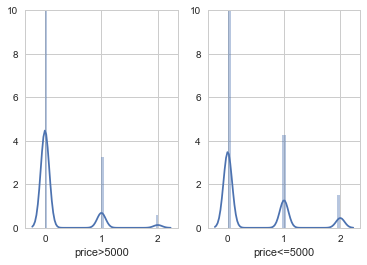

In [30]:
sns.distplot(X_train[X_train['price']>5000]['interest_level'],ax=plt.subplot(121));
plt.xlabel('price>5000');
axes=plt.gca()
axes.set_ylim([0,10])
sns.distplot(X_train[X_train['price']<=5000]['interest_level'],ax=plt.subplot(122));
plt.xlabel('price<=5000');
axes=plt.gca()
axes.set_ylim([0,10])

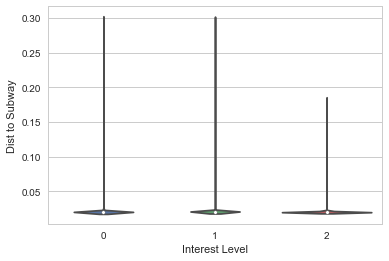

In [32]:
# X_train['dist_to_subway'].hist()
# X_train['bath==bed'].hist()

sns.violinplot(x="interest_level", y="dist_to_subway", order=[0, 1, 2],
            data=X_train)
plt.xlabel('Interest Level');
plt.ylabel('Dist to Subway');

(0, 100)

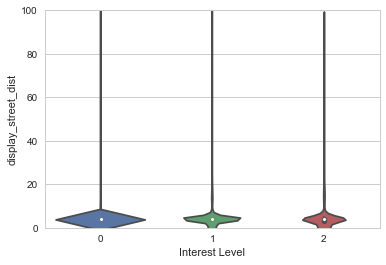

In [33]:
sns.violinplot(x="interest_level", y="display_street_dist", order=[0, 1, 2],
            data=X_train)
plt.xlabel('Interest Level');
plt.ylabel('display_street_dist');
axes=plt.gca()
axes.set_ylim([0,100])

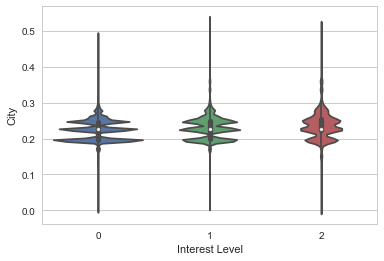

In [34]:
sns.violinplot(x="interest_level", y="city_mean_medium", order=[0, 1, 2],
            data=X_train)
plt.xlabel('Interest Level');
plt.ylabel('City');

(-73.9, -74.05)

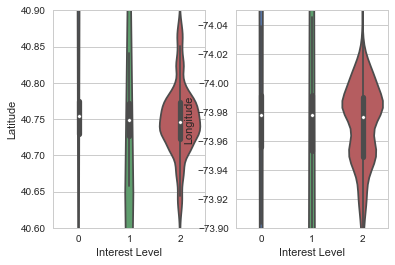

In [35]:
sns.violinplot(x="interest_level", y="latitude", order=[0, 1, 2],
            data=X_train, ax=plt.subplot(121))
plt.xlabel('Interest Level');
plt.ylabel('Latitude');
axes=plt.gca()
axes.set_ylim([40.6,40.9])
sns.violinplot(x="interest_level", y="longitude", order=[0, 1, 2],
            data=X_train, ax=plt.subplot(122))
plt.xlabel('Interest Level');
plt.ylabel('Longitude');
axes=plt.gca()
axes.set_ylim([-73.9,-74.05])

(0, 10)

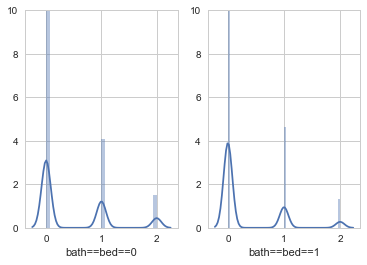

In [36]:
# sns.countplot(x='bath==bed', hue='interest_level', hue_order=[0, 1,2],
#               data=X_train);
# plt.xlabel('bath==bed');
# plt.ylabel('Number of occurrences');

sns.distplot(X_train[X_train['bath==bed']==0]['interest_level'],ax=plt.subplot(121));
plt.xlabel('bath==bed==0');
axes=plt.gca()
axes.set_ylim([0,10])
sns.distplot(X_train[X_train['bath==bed']==1]['interest_level'],ax=plt.subplot(122));
plt.xlabel('bath==bed==1');
axes=plt.gca()
axes.set_ylim([0,10])

In [117]:
X_train.groupby('num_photos').count().iloc[:,1]

num_photos
0     3615
1     1178
2     1334
3     4553
4     7887
5     8733
6     6739
7     4952
8     3972
9     1772
10    1390
11     784
12     816
13     377
14     232
15     197
16     152
17     109
18     114
19      53
20      87
21      21
22      73
23      16
24      16
25      17
26      19
27       7
28      11
29       4
30       5
31       1
32      62
34       5
35       3
36       3
37      18
38       6
43       1
44       1
45      12
46       2
50       1
60       1
68       1
Name: bedrooms, dtype: int64